In [15]:
# %load_ext iminizinc
%load_ext autoreload
%autoreload 2

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
# import ipywidgets as widgets
from ipywidgets import *
from IPython.display import display
import IPython
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from functools import *

import pandas_ta as ta

from datetime import datetime
# import talib
import pandas_ta as ta
# from talib.abstract import *
from math import *
from collections import OrderedDict
# import vectorbt as vbt    
import json
from decimal import *
getcontext().prec = 6
import seaborn as sns
from scipy.signal import find_peaks, peak_widths
import pickle
from scipy.signal import argrelextrema,argrelmin, argrelmax
from itertools import combinations


import sys, os
sys.path.append(os.path.abspath('..'))
from research.pkg.lib import *


# import mplfinance as mpf
%matplotlib inline

plt.rcParams['lines.linewidth'] = 1 

mpl.rcParams.update({'font.size': 10, 'lines.linewidth': 1, 'figure.dpi': 100})


In [2]:
# Create a DataFrame so 'ta' can be used.
df = pd.DataFrame()

# Help about this, 'ta', extension
# help(df.ta)
df.ta.indicators()
# df.a


Pandas TA - Technical Analysis Indicators - v0.3.14b0
Total Indicators & Utilities: 205
Abbreviations:
    aberration, above, above_value, accbands, ad, adosc, adx, alma, amat, ao, aobv, apo, aroon, atr, bbands, below, below_value, bias, bop, brar, cci, cdl_pattern, cdl_z, cfo, cg, chop, cksp, cmf, cmo, coppock, cross, cross_value, cti, decay, decreasing, dema, dm, donchian, dpo, ebsw, efi, ema, entropy, eom, er, eri, fisher, fwma, ha, hilo, hl2, hlc3, hma, hwc, hwma, ichimoku, increasing, inertia, jma, kama, kc, kdj, kst, kurtosis, kvo, linreg, log_return, long_run, macd, mad, massi, mcgd, median, mfi, midpoint, midprice, mom, natr, nvi, obv, ohlc4, pdist, percent_return, pgo, ppo, psar, psl, pvi, pvo, pvol, pvr, pvt, pwma, qqe, qstick, quantile, rma, roc, rsi, rsx, rvgi, rvi, short_run, sinwma, skew, slope, sma, smi, squeeze, squeeze_pro, ssf, stc, stdev, stoch, stochrsi, supertrend, swma, t3, td_seq, tema, thermo, tos_stdevall, trima, trix, true_range, tsi, tsignals, ttm_trend, ui, 

In [42]:

from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_blobs
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

In [16]:
pair = 'BTC_USDT'
timeframe = '1H'
exchange = 'binance'

# exchange = 'kucoin'
# odf = pd.read_json(f'../../freq-user-data/data/{exchange}/futures/{pair}-{timeframe}-futures.json'

def load_candles(exchange, pair, timeframe):
    odf = pd.read_json(f'../freq-user-data/data/{exchange}/{pair}-{timeframe.lower()}.json'
    ).dropna().set_axis(['timestamp', 'open', 'high', 'low', 'close', 'volume'], axis=1
    # odf['dtime'] = pd.to_datetime(odf['timestamp'], unit='ms', utc=True).dt.tz_localize(None)
    ).assign(dtime=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=True).dt.tz_localize(None)
    ).set_index('dtime').sort_index().drop('timestamp', axis=1)
    return odf


In [17]:
# odf

### All candle stick patterns under the sun

In [18]:

odf = load_candles(exchange, pair, timeframe)
odf = odf.iloc[odf.shape[0] // 2:
               ]
lret = odf.close.divide(odf.open).apply(np.log)

cdls = odf.ta.cdl_pattern(name="all")
cdls.shape, cdls.head(5)
# odf.close.ewm(lag).std()

((25854, 62),
                      CDL_2CROWS  CDL_3BLACKCROWS  CDL_3INSIDE  \
 dtime                                                           
 2020-08-02 22:00:00         0.0              0.0          0.0   
 2020-08-02 23:00:00         0.0              0.0          0.0   
 2020-08-03 00:00:00         0.0              0.0          0.0   
 2020-08-03 01:00:00         0.0              0.0          0.0   
 2020-08-03 02:00:00         0.0              0.0          0.0   
 
                      CDL_3LINESTRIKE  CDL_3OUTSIDE  CDL_3STARSINSOUTH  \
 dtime                                                                   
 2020-08-02 22:00:00              0.0           0.0                0.0   
 2020-08-02 23:00:00              0.0           0.0                0.0   
 2020-08-03 00:00:00              0.0           0.0                0.0   
 2020-08-03 01:00:00              0.0           0.0                0.0   
 2020-08-03 02:00:00              0.0           0.0                0.0   
 
  

### Moving Averages and rolling standard deviations and z-score

In [19]:


edf = pd.DataFrame({
    k: v 
    
    for lag in [6,12,21,50]
    for edf in [odf.close.ewm(lag)]
    for rdf in [odf.close.rolling(lag)]
    for [emean,estd] in [[edf.mean(), edf.std()]]
    for [rmean,rstd] in [[rdf.mean(), rdf.std()]]
    for k, v in [
        (f'ema_{lag}' , emean),
        (f'estd_{lag}' , estd),
        (f'eZscore', (odf.close - emean) / estd),
        (f'rma_{lag}' , rmean),
        (f'rstd_{lag}' , rstd),
        (f'rZscore', (odf.close - rmean) / rstd)
    ]

})
edf.shape, edf 

((25854, 18),
                             ema_6     estd_6   eZscore         rma_6  \
 dtime                                                                  
 2020-08-02 22:00:00  11118.320000        NaN       NaN           NaN   
 2020-08-02 23:00:00  11093.028462  33.212806 -0.700106           NaN   
 2020-08-03 00:00:00  11109.337953  33.901344  0.808592           NaN   
 2020-08-03 01:00:00  11112.017403  26.969373  0.258171           NaN   
 2020-08-03 02:00:00  11129.732480  39.970745  1.383913           NaN   
 ...                           ...        ...       ...           ...   
 2023-07-16 19:00:00  30311.204263  61.713073 -0.616560  30342.971667   
 2023-07-16 20:00:00  30305.552225  58.924336 -0.556942  30321.246667   
 2023-07-16 21:00:00  30303.709050  54.755354 -0.491698  30306.696667   
 2023-07-16 22:00:00  30306.183472  51.084633 -0.406491  30299.506667   
 2023-07-16 23:00:00  30295.584404  54.470594 -0.651734  30274.518333   
 
                         rstd_6   r

In [20]:
edf.columns.tolist()


['ema_6',
 'estd_6',
 'eZscore',
 'rma_6',
 'rstd_6',
 'rZscore',
 'ema_12',
 'estd_12',
 'rma_12',
 'rstd_12',
 'ema_21',
 'estd_21',
 'rma_21',
 'rstd_21',
 'ema_50',
 'estd_50',
 'rma_50',
 'rstd_50']

### Past plen periods flattened to current row

In [21]:
def flatten_past_n(odf, nper=None):
# plen = 6 * 2
    # if columns is None: columns = odf.columns.tolist()
    pcols = [f'{c}_m{nper-j}' for c in odf.columns for j in range(nper)]
    fdf = pd.DataFrame([
        (
            odf.iloc[i-nper:i].values.flatten()
        )
        #.shape
        for prange in [range(nper,odf.shape[0])]
        for i in prange
    ], index=odf.index.values[nper:]).set_axis(pcols, axis=1)

    return fdf

flatten_past_n(odf.iloc[:100][['high']], nper=4)#.index
# xdf = odf.join(fdf)#.join(edf)

# xdf[odf.columns.tolist() + [f'{c}_m{j}' for c in odf.columns for j in range(1,3) ]].tail()

,high_m4,high_m3,high_m2,high_m1
2020-08-03 02:00:00,11187.01,11139.24,11144.77,11179.10
2020-08-03 03:00:00,11139.24,11144.77,11179.10,11207.88
2020-08-03 04:00:00,11144.77,11179.10,11207.88,11194.64
2020-08-03 05:00:00,11179.10,11207.88,11194.64,11187.23
2020-08-03 06:00:00,11207.88,11194.64,11187.23,11200.00
...,...,...,...,...
2020-08-06 21:00:00,11868.00,11870.00,11900.00,11886.16
2020-08-06 22:00:00,11870.00,11900.00,11886.16,11875.00
2020-08-06 23:00:00,11900.00,11886.16,11875.00,11789.32
2020-08-07 00:00:00,11886.16,11875.00,11789.32,11786.18


In [22]:
# xdf.columns.tolist()

### Higher timeframes

In [34]:

H_periods = ['2H', '4H', '8H', '1D', '3D', '1W-Mon', '2W-Mon', '1M', 'Q', '1Y']
H_odfs = {
    timeframe: odf,
    **{period: odf.resample(period, closed='left', label='left').agg(OrderedDict([
        ('open', 'first'),
        ('high', 'max'),
        ('low', 'min'),
        ('close', 'last'),
        ('volume', 'sum'),
    ])).set_axis([f'H_{period}_{c}' for c in odf.columns], axis=1)
    for period in H_periods #[p.replace('-','_') for p in H_periods]
    }
}
# hdf = reduce(lambda x,y: pd.merge_asof(x,y, direction='backward', left_index=True, right_index=True) ,
#     [odf] + H_odfs)#.drop('dTime')
# hdf['2023-05-01':].head()

hdf = reduce(lambda x,y: pd.merge_asof(x,y, direction='backward', left_index=True, right_index=True) ,
    H_odfs.values())
hdf


,open,high,low,close,volume,H_2H_open,H_2H_high,H_2H_low,H_2H_close,H_2H_volume,...,H_Q_open,H_Q_high,H_Q_low,H_Q_close,H_Q_volume,H_1Y_open,H_1Y_high,H_1Y_low,H_1Y_close,H_1Y_volume
dtime,,,,,,,,,,,,,,,,,,,,,
2020-08-02 22:00:00,11132.76,11187.01,11104.00,11118.32,1583.241477,11132.76,11187.01,11032.25,11071.35,3120.716097,...,11132.76,12468.0,9825.0,10840.48,3.402466e+06,11132.76,28996.0,9825.0,28875.54,1.016154e+07
2020-08-02 23:00:00,11118.32,11139.24,11032.25,11071.35,1537.474620,11132.76,11187.01,11032.25,11071.35,3120.716097,...,11132.76,12468.0,9825.0,10840.48,3.402466e+06,11132.76,28996.0,9825.0,28875.54,1.016154e+07
2020-08-03 00:00:00,11071.36,11144.77,10936.00,11135.30,2773.288195,11071.36,11179.10,10936.00,11117.97,4541.324386,...,11132.76,12468.0,9825.0,10840.48,3.402466e+06,11132.76,28996.0,9825.0,28875.54,1.016154e+07
2020-08-03 01:00:00,11135.30,11179.10,11108.11,11117.97,1768.036191,11071.36,11179.10,10936.00,11117.97,4541.324386,...,11132.76,12468.0,9825.0,10840.48,3.402466e+06,11132.76,28996.0,9825.0,28875.54,1.016154e+07
2020-08-03 02:00:00,11117.97,11207.88,11117.97,11178.65,1779.632216,11117.97,11207.88,11115.07,11136.47,3446.561265,...,11132.76,12468.0,9825.0,10840.48,3.402466e+06,11132.76,28996.0,9825.0,28875.54,1.016154e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-16 19:00:00,30276.87,30298.71,30200.43,30252.93,632.928300,30381.93,30394.87,30200.43,30252.93,1395.531490,...,30447.31,31804.2,29500.0,30231.99,6.435133e+05,16607.48,31804.2,16470.0,30231.99,3.112045e+07
2023-07-16 20:00:00,30252.94,30296.84,30236.00,30271.64,390.372500,30252.94,30314.48,30236.00,30292.65,693.279020,...,30447.31,31804.2,29500.0,30231.99,6.435133e+05,16607.48,31804.2,16470.0,30231.99,3.112045e+07
2023-07-16 21:00:00,30271.64,30314.48,30271.64,30292.65,302.906520,30252.94,30314.48,30236.00,30292.65,693.279020,...,30447.31,31804.2,29500.0,30231.99,6.435133e+05,16607.48,31804.2,16470.0,30231.99,3.112045e+07


### Flatten N-number of past rows over higher time-frames

In [24]:
h_flats = [('2H', 12 * 3), ('4H', 6*7*1), ('8H', 3*7*4), ('1D', 7 * 4 ), ('3D', 10*3*3), ('1W-Mon', 4 * 4), ('2W-Mon', 2*2), ('1M', 3*0), ('Q', 4*1*0), ('1Y',0)]

FH_dfs = {
    timeframe: flatten_past_n(H_odfs[timeframe], nper=nper)
    for timeframe, nper in h_flats if nper > 0
}
FH_dfs

fhdf = reduce(lambda df1,df2: pd.merge_asof(df1,df2, direction='backward', left_index=True, right_index=True) ,
    [FH_dfs[tf] for (tf, nper) in h_flats if nper > 0]
)
fhdf.head()

,H_2H_open_m36,H_2H_open_m35,H_2H_open_m34,H_2H_open_m33,H_2H_open_m32,H_2H_open_m31,H_2H_open_m30,H_2H_open_m29,H_2H_open_m28,H_2H_open_m27,...,H_2W-Mon_low_m2,H_2W-Mon_low_m1,H_2W-Mon_close_m4,H_2W-Mon_close_m3,H_2W-Mon_close_m2,H_2W-Mon_close_m1,H_2W-Mon_volume_m4,H_2W-Mon_volume_m3,H_2W-Mon_volume_m2,H_2W-Mon_volume_m1
2020-08-05 22:00:00,11132.76,11187.01,11032.25,11071.35,3120.716097,11071.36,11179.10,10936.00,11117.97,4541.324386,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-06 00:00:00,11071.36,11179.10,10936.00,11117.97,4541.324386,11117.97,11207.88,11115.07,11136.47,3446.561265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-06 02:00:00,11117.97,11207.88,11115.07,11136.47,3446.561265,11136.27,11200.00,11126.44,11200.00,2676.427276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-06 04:00:00,11136.27,11200.00,11126.44,11200.00,2676.427276,11200.00,11244.99,11165.00,11197.11,3475.569952,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-06 06:00:00,11200.00,11244.99,11165.00,11197.11,3475.569952,11196.93,11240.00,11122.82,11127.98,4124.253197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
fhdf.columns.tolist()

['H_2H_open_m36',
 'H_2H_open_m35',
 'H_2H_open_m34',
 'H_2H_open_m33',
 'H_2H_open_m32',
 'H_2H_open_m31',
 'H_2H_open_m30',
 'H_2H_open_m29',
 'H_2H_open_m28',
 'H_2H_open_m27',
 'H_2H_open_m26',
 'H_2H_open_m25',
 'H_2H_open_m24',
 'H_2H_open_m23',
 'H_2H_open_m22',
 'H_2H_open_m21',
 'H_2H_open_m20',
 'H_2H_open_m19',
 'H_2H_open_m18',
 'H_2H_open_m17',
 'H_2H_open_m16',
 'H_2H_open_m15',
 'H_2H_open_m14',
 'H_2H_open_m13',
 'H_2H_open_m12',
 'H_2H_open_m11',
 'H_2H_open_m10',
 'H_2H_open_m9',
 'H_2H_open_m8',
 'H_2H_open_m7',
 'H_2H_open_m6',
 'H_2H_open_m5',
 'H_2H_open_m4',
 'H_2H_open_m3',
 'H_2H_open_m2',
 'H_2H_open_m1',
 'H_2H_high_m36',
 'H_2H_high_m35',
 'H_2H_high_m34',
 'H_2H_high_m33',
 'H_2H_high_m32',
 'H_2H_high_m31',
 'H_2H_high_m30',
 'H_2H_high_m29',
 'H_2H_high_m28',
 'H_2H_high_m27',
 'H_2H_high_m26',
 'H_2H_high_m25',
 'H_2H_high_m24',
 'H_2H_high_m23',
 'H_2H_high_m22',
 'H_2H_high_m21',
 'H_2H_high_m20',
 'H_2H_high_m19',
 'H_2H_high_m18',
 'H_2H_high_m17',
 

In [26]:

def plot_candles(wdf, ax=None, kwargs={}):
    if ax is None:
        fig, ax = plt.subplots(**kwargs)

    up, down = wdf[wdf.close >= wdf.open], wdf[wdf.close < wdf.open]
    col1,col2 = 'green','red'
    width, width2 = .8, .1
    # Plotting up prices of the stock
    ax.bar(up.index, up.close-up.open, width, bottom=up.open, color=col1)
    ax.bar(up.index, up.high-up.close, width2, bottom=up.close, color=col1)
    ax.bar(up.index, up.low-up.open, width2, bottom=up.open, color=col1)
    # Plotting down prices of the stock
    ax.bar(down.index, down.close-down.open, width, bottom=down.open, color=col2)
    ax.bar(down.index, down.high-down.open, width2, bottom=down.open, color=col2)
    ax.bar(down.index, down.low-down.close, width2, bottom=down.close, color=col2)    
    plt.xticks(rotation=30, ha='right')
    return ax

def plot_H_candles(wdf, ax=None, columns=['open', 'high', 'low', 'close'], column_prefix='', column_suffix='', n_spans=1., alpha=0.3, align='edge', kwargs={}):
    if ax is None:
        fig, ax = plt.subplots(**kwargs)
        
    copen, chigh, clow, cclose = [f'{column_prefix}{c}{column_suffix}' for c in columns]
    up, down = wdf[wdf[cclose] >= wdf[copen]], wdf[wdf[cclose] < wdf[copen]]
    col1,col2 = 'green','red'
    width, width2 = n_spans * 1.,  .02 * n_spans

    # # Plotting up prices of the stock
    ax.bar(up.index.values, up[cclose]-up[copen], width, bottom=up[copen], color=col1, alpha=alpha, align=align)
    ax.bar(up.index.values, up[chigh]-up[cclose], width, bottom=up[cclose], color=col1, alpha=alpha * 0.3, align=align)
    ax.bar(up.index.values, up[clow]-up[copen], width, bottom=up[copen], color=col1, alpha=alpha* 0.3, align=align)
    # # Plotting down prices of the stock
    ax.bar(down.index.values, down[cclose]-down[copen], width, bottom=down[copen], color=col2, alpha=alpha, align=align)
    ax.bar(down.index.values, down[chigh]-down[copen], width, bottom=down[copen], color=col2, alpha=alpha*0.3, align=align)
    ax.bar(down.index.values, down[clow]-down[cclose], width, bottom=down[cclose], color=col2, alpha=alpha*0.3, align=align)   
    return ax

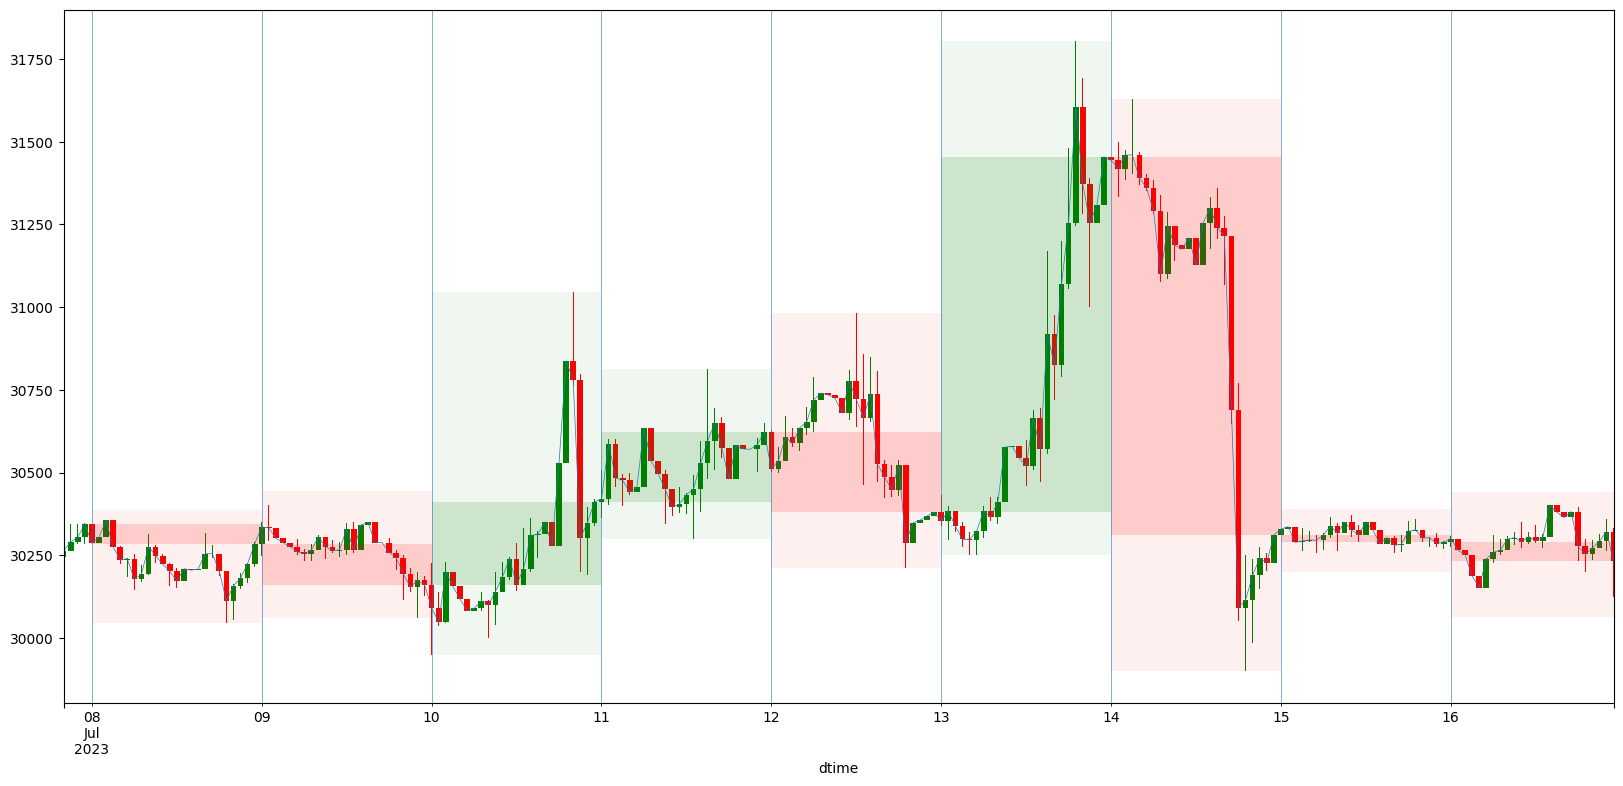

In [33]:
gdf = hdf[-220:]
ax = gdf.close.plot(figsize=(20,9), lw=0.5)

ghdf = H_odfs['1D'].loc[gdf.index[0]:gdf.index[-1]]
plot_candles(gdf, ax=ax)
plot_H_candles(ghdf, ax=ax, column_prefix='H_1D_', n_spans=24 * 1, alpha=0.2)

for h in ghdf.index.values: ax.axvline(h, lw=0.4)


### Normal fully-connected NN

In [299]:
# fhdf

In [16]:

xdf = odf.join(fhdf).dropna().iloc[-2048:,:]
# wlen = 6 * 2

# fdf = pd.DataFrame([
#     (
#         odf.iloc[i-wlen:i].values.flatten()
#     )
#     #.shape
#     for i in range(wlen,odf.shape[0])
# ], index=odf.index.values[wlen:])

# xdf = odf.join(fdf).join(edf).dropna()

# xdf.columns


timeout = 6
r2r = 2. / 1.
target_pct = 0.02
#################
# fu_highs = dxdf.high.rolling(timeout).max().shift(-timeout)
# fu_high_rets = fu_highs.divide(dxdf.close).apply(np.log).fillna(0).round(3)
# fu_lows = dxdf.low.rolling(timeout).min().shift(-timeout)
# fu_low_rets = fu_lows.divide(dxdf.close).apply(np.log).fillna(0).round(3)
#################

fu_highs = xdf.close.rolling(timeout).max().shift(-timeout)
fu_high_rets = fu_highs.divide(xdf.close).apply(np.log).fillna(0).round(3)
fu_lows = xdf.close.rolling(timeout).min().shift(-timeout)
fu_low_rets = fu_lows.divide(xdf.close).apply(np.log).fillna(0).round(3)
fu_r2r = - fu_low_rets / fu_high_rets
# fu_rets
# qs = np.quantile(fu_rets, np.linspace(0,1,6))
# y_cut, y_bins = pd.qcut(fu_rets, np.linspace(0,1,8), retbins=True)
# y = y_cut.map(lambda x: x.right).astype(float).values 
cats = pd.DataFrame(
    (fu_high_rets >= target_pct)
        # (fu_rets >= target_ret) & (fu_dds >= sl_ret)
        # fu_lows < ema - stds * 3
    & (fu_high_rets / (- fu_low_rets) > r2r)
        # np.where( fu_r2r < 1/2.5 , 1, np.where(fu_r2r > 2.5, 1, 0))
        # & (fu_low_rets > 0.01)
        # fu_low_rets > -0.01
     , index=xdf.index).dropna()#.astype(str)


# wsel = cats.shape[0] // 2
# sel_cats = cats.iloc[wsel:]
sel_cats = cats
y = sel_cats.values.ravel()
Xdf = xdf.loc[sel_cats.index] #.values

# iX_train, iX_test, y_train, y_test = train_test_split(i_samples, y, random_state=1, test_size=0.8)
Xdf_train, Xdf_test, y_train, y_test = train_test_split(Xdf, y, random_state=7, shuffle=False, test_size=0.3)
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, test_size=0.7)
X_train, X_test, = Xdf_train.values, Xdf_test.values

clf = MLPClassifier(solver='adam', max_iter=200, verbose=False, batch_size=1024, 
                    activation='relu', epsilon=1e-10, hidden_layer_sizes=(128,128,128)
                #     learning_rate_init = 1e-4,
                    )

scaler = StandardScaler().fit([*X_train, *X_test])

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

m = clf.fit(X_train_norm, y_train)

y_pred_train =  m.predict(X_train_norm)
y_pred_test =  m.predict(X_test_norm)

accuracy_train = accuracy_score(y_train,y_pred_train)
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
# y_pred_proba = m.predict_proba(X_test)

accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
# auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
# fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba[:,1])

# print('ROC curve (area = {:0.2f})'.format(auc_score))
print(f'Acc(train)={accuracy_train:.2f}\tAcc(test)={accuracy_train:.2f}')
print(f'Precision(Train)={precision_train:.2f}\tRecall(Train)={recall_train:.2f}')
print(f'Precision(Test)={precision_test:.2f}\tRecall(Test)={recall_test:.2f}')
print(f'----------- Classification Report: ------------')
report = classification_report(y_test, y_pred_test)
print(report)

Acc(train)=0.97	Acc(test)=0.97
Precision(Train)=0.87	Recall(Train)=0.39
Precision(Test)=0.00	Recall(Test)=0.00
----------- Classification Report: ------------
              precision    recall  f1-score   support

       False       0.97      1.00      0.98       594
        True       0.00      0.00      0.00        21

    accuracy                           0.97       615
   macro avg       0.48      0.50      0.49       615
weighted avg       0.93      0.97      0.95       615



/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/grenada/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gren

### LSTM

In [306]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, Conv1D, Flatten, Activation, Conv3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


In [54]:
df

,close
dtime,
2020-08-02 22:00:00,11118.32
2020-08-02 23:00:00,11071.35
2020-08-03 00:00:00,11135.30
2020-08-03 01:00:00,11117.97
2020-08-03 02:00:00,11178.65
2020-08-03 03:00:00,11136.47
2020-08-03 04:00:00,11171.32
2020-08-03 05:00:00,11200.00
2020-08-03 06:00:00,11190.50


In [289]:

# xdf = hdf.dropna().iloc[-2048:,:]
xdf = odf.join(fhdf).dropna().iloc[-2*2048:,:]

timeout = 2
# r2r = 2. / 1.
# target_pct = 0.02

# fu_highs = xdf.close.rolling(timeout).max().shift(-timeout)
# fu_high_rets = fu_highs.divide(xdf.close).apply(np.log).fillna(0).round(3)
# fu_lows = xdf.close.rolling(timeout).min().shift(-timeout)
# fu_low_rets = fu_lows.divide(xdf.close).apply(np.log).fillna(0).round(3)
# fu_r2r = - fu_low_rets / fu_high_rets
# cats = pd.DataFrame(
#     (fu_high_rets >= target_pct)
#     & (fu_high_rets / (- fu_low_rets) > r2r)
#      , index=xdf.index).dropna()

# sel_cats = cats
# y = sel_cats.values#.ravel()

y = xdf.high.rolling(timeout).max().shift(-timeout).divide(xdf.close).apply(np.log).dropna().round(3)
Xdf = xdf.loc[y.index] #.values


X = Xdf.values
y = y.values

dataset = Xdf.values

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
# scaler.fit(Xdf.values)
dataset = scaler.fit_transform(dataset)


# split into train and test sets
train_size = int(len(Xdf) * 0.3)
test_size = len(Xdf) - train_size
# dfXtrain, dfXtest = Xdf.iloc[0:train_size,:], Xdf.iloc[train_size:len(Xdf),:]
# dfYtrain, dfYtest = y.iloc[0:train_size,:], y.iloc[train_size:len(Xdf),:]

Xtrain, Xtest = dataset[0:train_size], dataset[train_size:len(Xdf)]
Ytrain, Ytest = y[0:train_size], y[train_size:len(Xdf)]


train_X = Xtrain.reshape((Xtrain.shape[0], 1, Xtrain.shape[1]))
test_X = Xtest.reshape((Xtest.shape[0], 1, Xtest.shape[1]))
train_y = Ytrain.reshape(-1,1)
test_y = Ytest.reshape(-1,1)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# print(len(Xtrain), len(Xtest))
# train_X.shape, test_X.shape


(1228, 1, 1505) (1228, 1) (2866, 1, 1505) (2866, 1)


In [213]:
xdf.close.rolling(timeout).max().shift(-timeout).divide(xdf.close).apply(np.log).dropna().round(3)

dtime
2023-01-27 08:00:00    0.007
2023-01-27 10:00:00    0.010
2023-01-27 12:00:00    0.011
2023-01-27 14:00:00    0.009
2023-01-27 16:00:00    0.002
                       ...  
2023-07-16 06:00:00    0.005
2023-07-16 08:00:00    0.003
2023-07-16 10:00:00    0.004
2023-07-16 12:00:00    0.004
2023-07-16 14:00:00   -0.001
Name: close, Length: 2044, dtype: float64

In [308]:
...
# design network
model = Sequential([
    LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])),
    Conv3D(filters=256, kernel_size=5, padding='same', activation='relu', input_shape=(1,X.shape[0])),
    Flatten(),
    Dense(64),
    Activation('relu'),
    Dense(32),
    Activation('softmax'),
    Dense(1),
])
model.add(LSTM(4, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(15))
# model.add(Dense(10))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=150, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

ValueError: Input 0 of layer "conv1d" is incompatible with the layer: expected min_ndim=3, found ndim=2. Full shape received: (None, 4)

In [303]:
yhat.shape, test_y.shape

((2866, 1), (2866, 1))

In [304]:
from numpy import concatenate
import sklearn

...
# make a prediction
yhat = model.predict(test_X)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # invert scaling for forecast
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(test_y.reshape(-1), yhat.reshape(-1)))
print('Test RMSE: %.3f' % rmse)

sklearn.metrics.mean_absolute_error(test_y, yhat)
# print(f'----------- Classification Report: ------------')
# report = classification_report(test_y.reshape(1,-1), yhat.reshape(1,-1))
# print(report)

90/90 [==============================] - 0s 731us/step
Test RMSE: 0.012


0.007743154434423371

In [216]:
yhat.shape, test_y.shape

((1431, 1), (1431, 1))

In [234]:
zdf = pd.DataFrame([test_y.reshape(-1), yhat.reshape(-1)]).T
# zdf.apply(lambda x: x[1] - x[0], axis=1).pow(2).sum() / yhat.shape[0]
# zdf[zdf[1] > 0.01]
# zdf[1].abs().describe()

count    1.431000e+03
mean     4.090025e-04
std      2.456778e-04
min      1.725857e-07
25%      2.854555e-04
50%      3.822918e-04
75%      4.894982e-04
max      2.754945e-03
Name: 1, dtype: float64

In [240]:
test_y.reshape(-1), yhat.reshape(-1)

(array([ 0.045,  0.038,  0.035, ...,  0.004,  0.004, -0.001]),
 array([ 0.00275495,  0.00241698,  0.00234453, ..., -0.00051619,
        -0.0005163 , -0.00051599], dtype=float32))

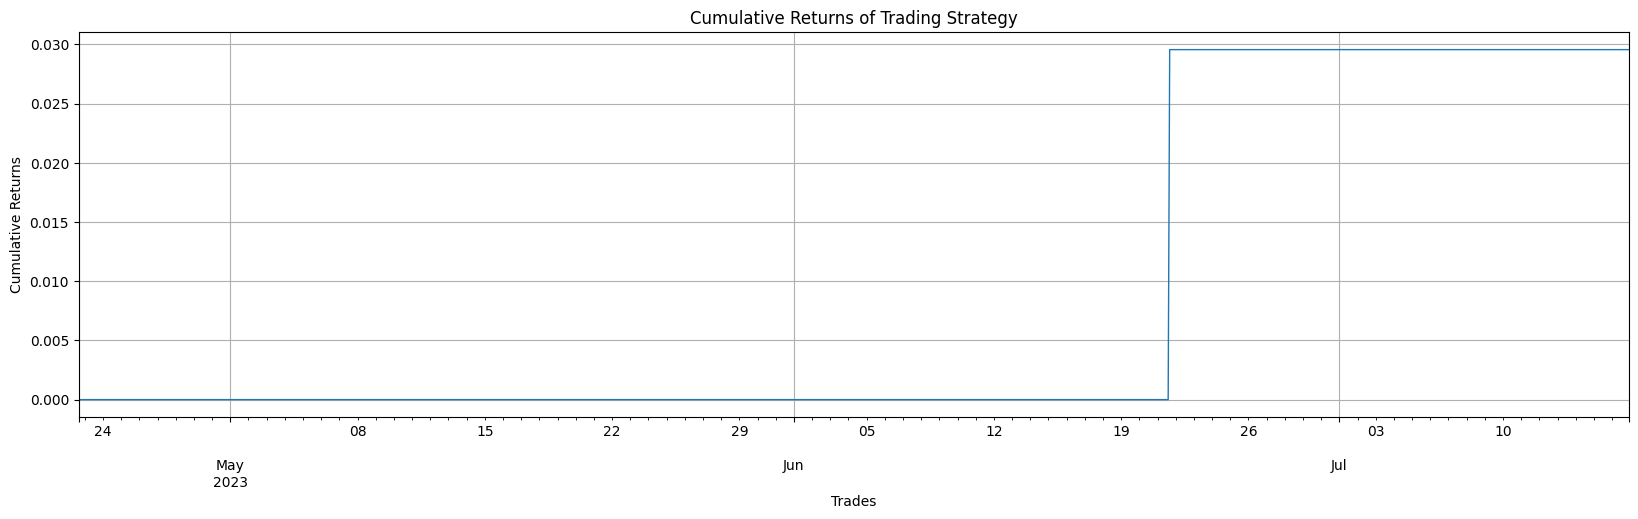

In [509]:


# Assuming you have your OHLC data in a CSV file or any other source
# df = pd.read_csv('ohlc_data.csv')  # Replace 'ohlc_data.csv' with the actual file path
df = Xdf_test[['open', 'high', 'low', 'close']].assign(signal=y_pred_test)#.iloc[:200,:]#.copy()
# signals = y_pred_test
# Assuming you have an array of signals indicating when to go long (1) or not (0)
# signals = np.array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0])  # Replace this with your actual signals array

take_profit_pct = 0.03  # 2% take-profit level
stop_loss_pct = 0.009    # 1% stop-loss level

entry_prices = df.close * (df.signal == 1)
exit_prices = entry_prices * (1. + take_profit_pct)
stop_prices = entry_prices * (1. - stop_loss_pct)
a_close = df.close.values
a_high = df.high.values
a_low = df.low.values
a_signal = df.signal.values



returns = np.zeros(df.shape[0])
# entry_price, exit_price, stop_price = None,None,None
i_pos = None
for i in range(len(df)):
    if a_signal[i] == 1 and i_pos is None:  # Enter long position
        i_pos = i
        entry_price = entry_prices.iloc[i]; exit_price = exit_prices[i]; stop_price=stop_prices[i]

    elif i_pos is not None:  # Check if take-profit or stop-loss is hit
        # exit_price = df['close'].iloc[i]
        if a_low[i] <= stop_prices[i_pos] or a_high[i] >= exit_prices[i_pos]:
            if a_low[i] <= stop_prices[i_pos]:
                exit_price = stop_prices[i_pos]  # Adjust exit price to take-profit
            elif a_high[i] >= exit_prices[i_pos] :
                exit_price =  exit_prices[i_pos]  # Adjust exit price to stop-loss
            returns[i] = log(exit_price / entry_price) 
            # entry_price, exit_price, stop_price = None,None,None
            i_pos = None

# Check if there's an open position at the end of the data
# if current_position == 1:
#     exit_price = df['close'].iloc[-1]
#     if exit_price >= entry_price * (1 + take_profit_pct):
#         exit_price = entry_price * (1 + take_profit_pct)  # Adjust exit price to take-profit
#     else:
#         exit_price = entry_price * (1 - stop_loss_pct)  # Adjust exit price to stop-loss
#     returns.append((exit_price / entry_price) - 1)

df['pnl'] = returns
df['cum_ret'] = df.pnl.fillna(0).cumsum()

tdf = pd.DataFrame(index=xdf.index).join(df.pnl).fillna(0)
tdf['cum_ret'] = tdf.pnl.cumsum()

# plt.plot()
tdf['cum_ret'].plot(figsize=(20,5))
plt.xlabel('Trades')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Trading Strategy')
plt.grid()
plt.show()


In [492]:
tdf[tdf.pnl ]

,open,high,low,close,signal,pnl,cum_ret
dtime,,,,,,,
2021-04-29 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-29 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-29 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-29 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-29 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-07-16 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-16 16:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-16 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [482]:
# (df.pnl < 0).value_counts()
(df.pnl == 0).sum()

165

In [383]:

xpdf = Xdf_test[['open', 'high', 'low', 'close']].assign(signal=y_pred_test)

# da_printer(xpdf, 'nn-kitchen-sink', strategy_params = {})
strategy_params = {}
strategy =  'nn-kitchen-sink'
strategy_params_json = f'./par-{strategy}.json'
    ### windowing
olen = xpdf.shape[0]
w2log = 7
wlen = 2**w2log
w2len = wlen // 2
nwin = olen // w2len
# olen, w2log, wlen, w2len, nwin
###
fu_params = {
        'w2log':    {'wdg': IntSlider(description="n2", min=0, max=13, step=1, value=w2log)}, 
        'w':        {'wdg': IntSlider(description="w", min=0, max=nwin, step=1, value=1)},
        "candles":  {"wdg": Checkbox(value=True, description='Candles', disabled=False)},
    }

def update_sl_w_range(kwargs):
    print('*kwargs', kwargs)
    wlen = 2**kwargs['new'] #fu_params['w2loog'].value

    w2len = wlen // 2
    nwin = olen // w2len
    fu_params['w']['wdg'].value = 0
    fu_params['w']['wdg'].max = nwin
fu_params['w2log']['wdg'].observe(update_sl_w_range, 'value')

all_params = {
    ** fu_params,
    **strategy_params
}
wdgts = [pv['wdg'] for pk, pv in all_params.items()]

ui = widgets.VBox([
    widgets.VBox([widgets.HBox(wdgts[i:i+4]) for i in range(0, len(wdgts), 4)])
])

if os.path.exists(strategy_params_json):
    with open(strategy_params_json) as f: 
        js = json.loads(f.read());
        for k, v in all_params.items(): 
            if k in js: v['wdg'].value=js[k];

else: print(f'File not found: {strategy_params_json}')

wdf=None
def printer(**pkwargs):   
    w2log, w, candles = pkwargs['w2log'], pkwargs['w'], pkwargs['candles'],

    wlen = 2**w2log
    w2len = wlen // 2
    nwin = olen // w2len

    with open(strategy_params_json, "w") as f: f.write(json.dumps({k: v['wdg'].value for k, v in all_params.items()}))
    
    
    wst = w * w2len
    wed = min(olen-1, wst + wlen)
    wlen = wed - wst + 1
    if olen - wed + 1 < w2len: wed = - 1
    # print(f'wst:{wst}, wed:{wed}')
    wdf = xpdf.iloc[wst:wed,:].copy()    


    wsignals = wdf.loc[wdf.signal].index

    print(f'N={len(wdf)}; Period: {wdf.index[0] - wdf.index[-1]}, Start: {wdf.index[0]}, End: {wdf.index[-1]}\n')
    # print('plt.rcParam["lines.linewidth"]: ', plt.rcParams["lines.linewidth"])
    fig = plt.figure(layout="constrained", figsize=(20,6))
    ax_dict = fig.subplot_mosaic("""
        AAA
        BBB
        XYZ
        """,
        height_ratios=[3, 1, 1],
    )
    identify_axes(ax_dict)
    plt.xticks(rotation=30, ha='right')
    axa = ax_dict['A']
    axb = ax_dict['B']
    wdf.close.multiply(1.1).plot(ax=axa, lw=0.4, alpha=0.);


    if candles: plot_candles(wdf, ax=axa)
    else: wdf.close.plot(ax=axa, c='b');
    for ix in wsignals: axa.axvline(ix, c='g')

    # if draw_func is not None: draw_func(ax_dict, indicators, signals, pkwargs)

    
    plt.show()
    
out = widgets.interactive_output(printer, {
        **{k : v['wdg'] for k,v in all_params.items()}
    });
x = display(ui, out);


*kwargs {'name': 'value', 'old': 7, 'new': 5, 'owner': IntSlider(value=5, description='n2', max=13), 'type': 'change'}


Output()

In [98]:

# sel_cats = cats.iloc[:wsel]
test_cats = cats.iloc[wsel:]
y_test = test_cats.values
X_test = xdf.loc[test_cats.index].values

# scaler = StandardScaler().fit(X_test)

# X_train_norm = StandardScaler().fit(X_test).transform(X_train)

X_train_norm = scaler.transform(X_train)

X_test_norm = scaler.transform(X_test)
y_pred_test =  m.predict(X_test_norm)


accuracy_test = accuracy_score(y_test, y_pred_test)
precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
print(f'Precision(Test)={precision_test:.2f}\tRecall(Test)={recall_test:.2f}')
print(f'----------- Classification Report: ------------')
report = classification_report(y_test, y_pred_test)
print(report)

Precision(Test)=0.11	Recall(Test)=0.41
----------- Classification Report: ------------
              precision    recall  f1-score   support

       False       0.90      0.62      0.73      5588
        True       0.11      0.41      0.18       659

    accuracy                           0.60      6247
   macro avg       0.51      0.51      0.46      6247
weighted avg       0.82      0.60      0.68      6247



In [38]:
def print(i):
    j = iX_test[i]
    wdf = odf.iloc[j - wlen:j + timeout].copy()
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.subplots(1,1)
    ax1.axvline(odf.index[j])
    # plot_candles(wdf,ax=ax1)
    wdf.close.plot(ax=ax1, color='red' if y_pred_test[i] else 'gray')

interactive(print, i=(0,iX_test.shape[0]))

interactive(children=(IntSlider(value=819, description='i', max=1639), Output()), _dom_classes=('widget-intera…

In [100]:
256 * 128 *128

4194304

In [102]:
7 * 7 * 128 * 3

18816